In [1]:
import scipy.stats as stats
import scipy.integrate as integrate
import scipy.special as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib notebook

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import axes3d  

from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'font.size': 14,
    'legend.fontsize': 13,
    'pgf.rcfonts': False
})

# matplotlib.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.linewidth": 0.4})


In [2]:
from scipy.stats import norm

def blackScholes(r, S, K, T, sigma, type="c"):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if type == "c":
        price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
    elif type == "p":
        price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
    return price

In [3]:
def bs_call(S, K, T, r, vol):
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * stats.norm.cdf(d1) - np.exp(-r * T) * K * stats.norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):
#     print("calc vol")
#     print(target_value, S, K, T, r)

    MAX_ITERATIONS = 200
    PRECISION = 1.0e-4
    sigma = 0.564
    path = [sigma]
    for i in range(0, MAX_ITERATIONS):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        diff = target_value - price  # our root
        if (abs(diff) < PRECISION).all() :
#             print("vol found %f" % sigma)
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)
        path.append(sigma)
#     print("_vol found %f" % sigma)
    return sigma # value wasn't found, return best guess so far

bs_call(100,90,1,0.1,0.3), blackScholes(0.1, 100, 90, 1, 0.3)#, find_vol(20.3, 100, 100, 1, 0.1)

(22.510077370599106, 22.510077370599106)

0.3000000048090874


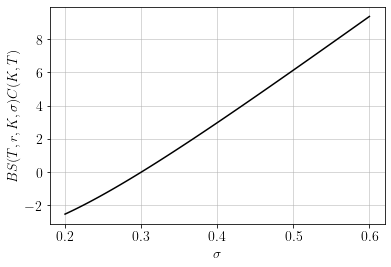

In [4]:
X = np.linspace(0.2, 0.6, 100)
y = [bs_call(100, 90, 1, 0.1, x) - bs_call(100,90,1,0.1,0.3) for x in X]

progress = find_vol(bs_call(100,90,1,0.1,0.3), 100, 90, 1, 0.1)
print(progress)

fig, ax = plt.subplots()
ax.plot(X,y, color='black')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$BS(T,r,K,\sigma) C(K,T)$')
plt.grid(linewidth = 0.5)
# ax.scatter(progress, [bs_call(100, 90, 1, 0.1, p) - bs_call(100,90,1,0.1,0.3) for p in progress])
# for i, p in enumerate(progress):
#     print(i,p)
#     plt.text(p, bs_call(100, 90, 1, 0.1, p) - bs_call(100,90,1,0.1,0.3) -1, r'$\sigma_' + str(i) + r'$')
# #     plt.text(progress, 0, str(i))
# plt.show()
# plt.savefig("newton.pgf")

In [5]:
def switchingCall(X0,K,T,r,s0,s1,l0,l1, c0=False, c1=False):
    
    def s(x, T):
        return s0**2 * x + s1**2 * (T-x)

    def g0(x, T):
        return np.sqrt(l0*l1*x/(T-x))

    def g1(x, T):
        return np.sqrt(l0*l1*(T-x)/x)

    def h(x, T):
        return np.sqrt(l0*l1*x*(T-x))

    def f0(x, T):
        return np.exp(-l0 * x - l1 * (T-x))*(g0(x,T)*sp.iv(1, 2*h(x,T)) + l0 * sp.iv(0, 2*h(x,T)))

    def f1(x,T):
        return np.exp(-l0 * x - l1 * (T-x))*(g1(x,T)*sp.iv(1, 2*h(x,T)) + l1 * sp.iv(0, 2*h(x,T)))

    def integrand0(x, K, T):
        return blackScholes(r, X0, K, T, np.sqrt(s(x,T)/T)) * f0(x, T)

    def integrand1(x, K, T):
        return blackScholes(r, X0, K, T, np.sqrt(s(x,T)/T)) * f1(x, T)

    def C0(K, T):
        return blackScholes(r, X0, K, T, s0)*np.exp(-l0*T) + integrate.quad(integrand0, 0, T, args=(K,T))[0]

    def C1(K, T):
        return blackScholes(r, X0, K, T, s1)*np.exp(-l0*T) + integrate.quad(integrand1, 0, T, args=(K,T))[0]
    
    if c0:
        return C0(K,T)
    if c1:
        return C1(K,T)
    
#     print(C0(K,T), C1(K,T))
    return l1/(l0+l1) * C0(K,T) + l0/(l0+l1) * C1(K,T)

# C0(100, 1), C1(100,1), 
# print(switchingCall(100, 100, 1, 0.05, 0.25, 0.15, 0.5, 0.5))
# 11.70507183782266

# 11.70503, 9.33921
print(switchingCall(100,90,1,0.1,0.2,0.3,1,1,c0=True))
print(switchingCall(100,90,1,0.1,0.2,0.3,1,1,c1=True))
switchingCall(100, 100, 1, 0.05, 0.25, 0.15, 0.5, 0.5), (11.70503 + 9.33921)/2

20.721592925976864
21.812016932833806


(10.522160999339352, 10.522120000000001)

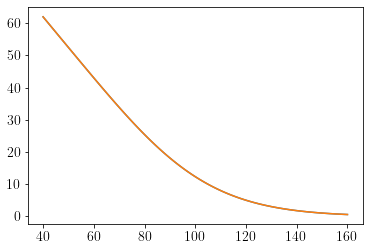

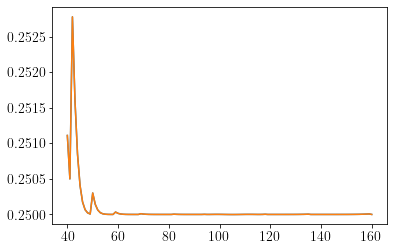

In [6]:
import matplotlib.pyplot as plt

strikes = [k for k in range(40,161)]
plt.plot(strikes, [switchingCall(100, K, 1, 0.05, 0.25, 0.25, 0.5, 0.5) for K in strikes])
plt.plot(strikes, [bs_call(100, K, 1, 0.05, 0.25) for K in strikes])
plt.show()
plt.plot(strikes, [find_vol(switchingCall(100, K, 1, 0.05, 0.25, 0.25, 0.5, 0.5), 100, K, 1, 0.05) for K in strikes])
plt.plot(strikes, [find_vol(bs_call(100, K, 1, 0.05, 0.25), 100, K, 1, 0.05) for K in strikes])

plt.show()

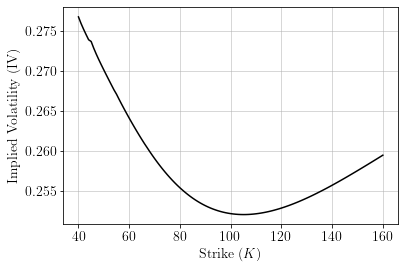

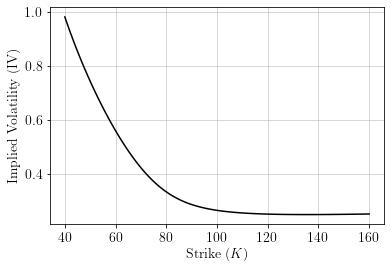

In [7]:
import matplotlib.pyplot as plt

strikes = [k for k in range(40,161)]
for l in range(10,11,1):
    plt.plot(strikes, [find_vol(switchingCall(100, K, 1, 0.05, 0.2, 0.3, 1, 1), 100, K, 1, 0.05) for K in strikes], color='black')

plt.xlabel(r'Strike $(K)$')
plt.ylabel(r'Implied Volatility (IV)')
plt.grid(linewidth = 0.5)
# plt.savefig("vol_smile_1_1.pgf", bbox_inches='tight')
plt.show()

import matplotlib.pyplot as plt

strikes = [k for k in range(40,161)]
for l in range(10,11,1):
    plt.plot(strikes, [find_vol(switchingCall(100, K, 1, 0.05, 0.2, 0.3, 1, 2), 100, K, 1, 0.05) for K in strikes], color='black')

plt.xlabel(r'Strike $(K)$')
plt.ylabel(r'Implied Volatility (IV)')
plt.grid(linewidth = 0.5)
# plt.savefig("vol_smile_1_2.pgf", bbox_inches='tight')
plt.show()

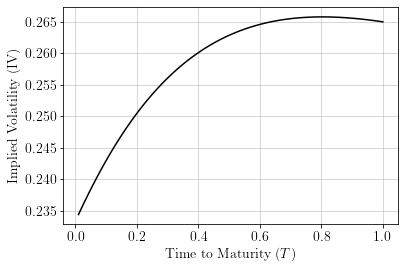

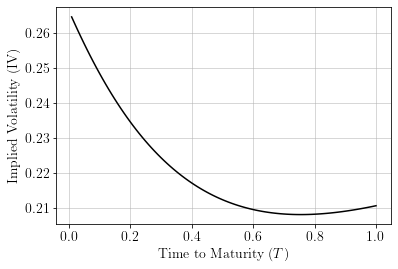

In [9]:
import matplotlib.pyplot as plt

taus = [t/100 for t in range(1,101,1)]
plt.plot(taus, [find_vol(switchingCall(100, 100, tau, 0.05, 0.2, 0.3, 1, 2), 100, 100, tau, 0.05) for tau in taus], color='black')

plt.xlabel(r'Time to Maturity $(T)$')
plt.ylabel(r'Implied Volatility (IV)')
plt.grid(linewidth = 0.5)
# plt.savefig("vol_term_1_2.pgf", bbox_inches='tight')
plt.show()

import matplotlib.pyplot as plt

taus = [t/100 for t in range(1,101,1)]
plt.plot(taus, [find_vol(switchingCall(100, 100, tau, 0.05, 0.2, 0.3, 2, 1), 100, 100, tau, 0.05) for tau in taus], color='black')

plt.xlabel(r'Time to Maturity $(T)$')
plt.ylabel(r'Implied Volatility (IV)')
plt.grid(linewidth = 0.5)
# plt.savefig("vol_term_2_1.pgf", bbox_inches='tight')
plt.show()

In [10]:
x = np.linspace(440, 480, 10)
y = np.linspace(0.1, 1, 10)

X, Y = np.meshgrid(x, y)

Z = np.vectorize(switchingCall)(445,X, Y, 0.05, 0.2,0.4,1,2)
print(X.shape,Y.shape,Z)
Z = np.vectorize(find_vol)(Z, 445, X, Y, 0.05)
Z.shape

(10, 10) (10, 10) [[19.56792417 17.10892459 14.88269346 12.88639655 11.11280732  9.55087389
   8.18648269  7.00333197  5.98382781  5.109926  ]
 [27.9800091  25.5173421  23.21872878 21.08274097 19.10643856 17.28549742
  15.61437352 14.08649318 12.6944589  11.43026048]
 [34.97041501 32.49913689 30.16097186 27.95489024 25.87907029 23.93095368
  22.10731355 20.404332   18.81768425 17.34262649]
 [41.11092208 38.63650225 36.27642542 34.02984979 31.89543935 29.87139513
  27.95549211 26.14512042 24.43732991 22.82887663]
 [46.62344119 44.15186833 41.78160234 39.51191288 37.3417299  35.26966389
  33.29402897 31.41286831 29.6239814  27.92495233]
 [51.63161289 49.16792211 46.79575518 44.51445725 42.32312513 40.22062144
  38.20559054 36.27647572 34.43153743 32.66887221]
 [56.21966448 53.76776339 51.39966943 49.11478347 46.91231679 44.79130166
  42.75060297 40.78893055 38.90485229 37.09680759]
 [60.45182144 58.01460394 55.65489347 53.37213444 51.16562188 49.03450964
  46.97781922 44.99444914 43.0831

(10, 10)

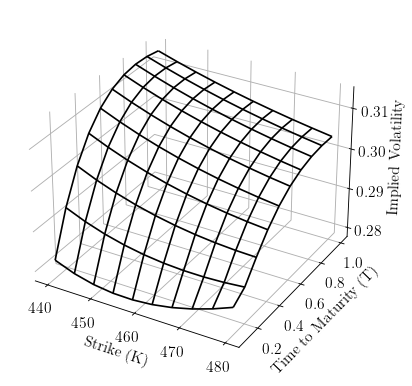

In [11]:
plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')

ax.plot_wireframe(X, Y, Z, color='black')
ax.set_xlabel('Strike (K)')
ax.set_ylabel('Time to Maturity (T)')
ax.set_zlabel('Implied Volatility')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.show()

In [12]:
import numpy as np
import random
from time import time
t0 = time()

# Given parameters
Maturities = [0.1, 0.2, 0.5, 1, 2, 3]
S0 = 100.0
Initial_State = 2
sig1 = 0.2
sig2 = 0.3
r1 = mu1 = 0.1
r2 = mu2 = 0.1
n = 100000
K = 90.0
l1 = 1.0
l2 = 1.0

print ('European Call Option Price under RSGBM via MC method\n')
print ('Maturity STATE %d \n' % Initial_State)
for j in range(len(Maturities)):
    T = Maturities[j]
    SumofTermVals = 0.0
    TermValOneRun = 0.0
    listOfTermVals = []
    for x in range(n):
        LogStock = float(np.log(S0))
        Curr_Time = 0.0
        tau1 = 0.0
        Curr_State = Initial_State
        #Determine our occupation time of state 1
        while Curr_Time < T:
            #Determine time until next change of state
            # p(tau_i>t)=exp(-lambda_i * t)
            p = random.uniform(0, 1)
            if Curr_State==1:
                ExpRV = -1*np.log(p)/l1
            else:
                ExpRV = -1*np.log(p)/l2
        
            #If the next state change is before maturity, increment tau
            if Curr_Time + ExpRV < T and Curr_State==1:
                tau1 = tau1 + ExpRV
            # Else there is no state change between now and maturity
            else:
                if Curr_State==1:
                    tau1 = tau1 + T - Curr_Time
            #Increment to next switch time
            Curr_Time = Curr_Time + ExpRV
            #Switch State
            if Curr_State==1:
                Curr_State = 2
            else:
                Curr_State = 1
        # Obtain a pseudo-random sample from
        # standard normal distribution
        SimRand = float(np.random.standard_normal(1))
        #Calculate our terminal log stock price
        LogStock = LogStock + (mu1 - 0.5 * sig1**2) * tau1 + \
            (mu2 - 0.5 * sig2**2) * (T-tau1) \
            + SimRand*np.sqrt(tau1*sig1**2 \
            + (T-tau1)*sig2**2)
        #Calculate terminal option value
        TermValOneRun = np.maximum(0, np.exp(LogStock) - K)
        #Add terminal option value running total
        SumofTermVals = SumofTermVals + TermValOneRun
        listOfTermVals.append(TermValOneRun)
        
    callprice = (SumofTermVals / n) * np.exp(-1 * ((tau1 * r1 )+ r2*(T-tau1)))
    
    s2 = np.var(listOfTermVals, ddof=1)
    confidence = 1.96 * np.sqrt(s2/n)
    
    analytical = switchingCall(S0,K,T,r1,sig1,sig2,l1,l2, c1=True)
    print ('%20f %2.3f %2.3f %2.3f (%2.3f - %2.3f)\n' % (T, analytical, callprice, callprice-analytical, callprice-confidence, callprice+confidence))
tn = time()-t0
print ("\n Duration in seconds %7.3f \n" %tn)

European Call Option Price under RSGBM via MC method

Maturity STATE 2 

            0.100000 11.361 11.419 0.058 (11.365 - 11.473)

            0.200000 12.889 12.870 -0.019 (12.797 - 12.943)

            0.500000 16.718 16.646 -0.072 (16.533 - 16.760)

            1.000000 21.812 21.857 0.045 (21.689 - 22.024)

            2.000000 30.085 30.200 0.115 (29.931 - 30.469)

            3.000000 37.062 37.372 0.310 (37.000 - 37.744)


 Duration in seconds   9.718 



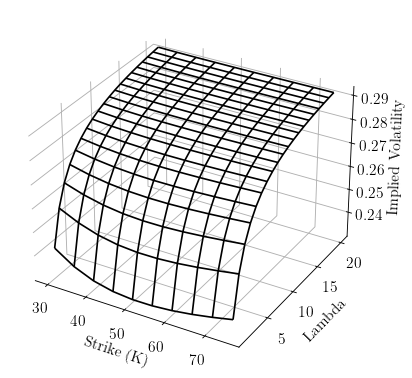

In [13]:
x = np.linspace(30, 75, 10)
y = np.linspace(1, 20, 20)

X, Y = np.meshgrid(x, y)

Z = np.vectorize(switchingCall)(50,X, 1, 0.04, 0.2,0.3,Y,1, c0=True)
Z = np.vectorize(find_vol)(Z, 50, X, 1, 0.04)
Z.shape

plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')

ax.plot_wireframe(X, Y, Z, color='black')
ax.set_xlabel('Strike (K)')
ax.set_ylabel('Lambda')
ax.set_zlabel('Implied Volatility')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
plt.show()
# default is -60, 30
# 120, 30

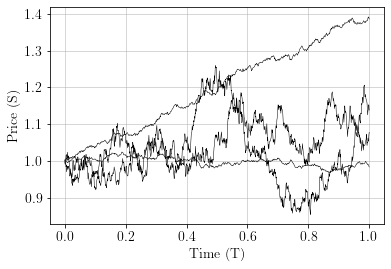

In [14]:
import matplotlib.pyplot as plt

h=0.001
MU = [0.3, 0.3, 0, 0]
SIG = [0.05, 0.3, 0.05, 0.3]
for i in range(4):
    mu = MU[i]
    sigma = SIG[i]
    Z = np.random.normal(0, 1, 1000)

    sim = [(mu - (sigma**2)/2)*h + sigma*np.sqrt(h)*Z[i] for i in range(1000)]
    plt.plot(np.linspace(0,1,1000), np.exp(np.cumsum(sim)), lw=0.5, color='black')

plt.ylabel(r'Price (S)')
plt.xlabel(r'Time (T)')
plt.grid(linewidth = 0.5)
# plt.savefig("samplepaths.pgf", bbox_inches='tight')
plt.show()